In [1]:
# Modules used on the analysis
import sys
import pickle
sys.path.append("../tools/")
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import seaborn as sns
import matplotlib.pyplot as plt

# set random seed
#np.random.seed(1234)

In [2]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# Create DataFrame from data_dict 
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')

In [3]:
# Inspect Dataframe
df_enron.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


In [4]:
# Drop email_address column
df_enron = df_enron.drop('email_address', axis=1)

In [5]:
# Verify datatypes for each column
df_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
loan_advances                146 non-null object
bonus                        146 non-null object
restricted_stock_deferred    146 non-null object
deferred_income              146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
from_poi_to_this_person      146 non-null object
exercised_stock_options      146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
long_term_incentive          146 non-null object
shared_receipt_with_poi      146 non-null object


In [6]:
# Change columns type to numeric
df_enron = df_enron.apply(pd.to_numeric, errors='coerce')

# Check Dataframe after to_numeric
df_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
from_poi_to_this_person      86 non-null float64
exercised_stock_options      102 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
long_term_incentive          66 non-null float64
shared_receipt_with_poi      86 non-null float6

In [7]:
# Fillna with 0 to replace NaN
df_enron = df_enron.fillna(0.0)

In [8]:
# Rescale feature values with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df_enron.drop('poi', axis=1))
y = df_enron.poi

In [9]:
# Inspect X
X.shape

(146, 19)

In [10]:
# As mentioned on the report, we applied PCA to define outliers
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
dim_red = pca.fit_transform(X)

# Transform PCA results into Dataframe
pca_df = pd.DataFrame(dim_red, columns=[
    'PCA1', 'PCA2'], index=df_enron.index)

# Concatenate with y series as for labels
pca_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1)

# Get z-score for each component
pca_df['PCA1_zscore'] = (pca_df.PCA1 - pca_df.PCA1.mean()) / pca_df.PCA1.std()
pca_df['PCA2_zscore'] = (pca_df.PCA2 - pca_df.PCA2.mean()) / pca_df.PCA2.std()

# Get rows that are 3 standard deviations away from meanlist_outliers_pca
list_outliers_pca = (pca_df[(np.abs(pca_df.PCA1_zscore) > 3)
                            | (np.abs(pca_df.PCA2_zscore) > 3)]).index

In [11]:
list_outliers_pca

Index(['BELDEN TIMOTHY N', 'KEAN STEVEN J', 'KITCHEN LOUISE',
       'LAVORATO JOHN J', 'SHAPIRO RICHARD S', 'TOTAL'],
      dtype='object')

In [12]:
# Inspect pca_df
pca_df.head()

,PCA1,PCA2,poi,PCA1_zscore,PCA2_zscore
ALLEN PHILLIP K,0.021015,0.194580,False,0.069580,0.702114
BADUM JAMES P,-0.040584,-0.172437,False,-0.134378,-0.622213
BANNANTINE JAMES M,-0.024012,-0.066678,False,-0.079504,-0.240597
BAXTER JOHN C,0.040294,-0.169535,False,0.133416,-0.611740
BAY FRANKLIN R,-0.027090,-0.171985,False,-0.089698,-0.620583


In [13]:
# Function to create new column with labels of poi
def poi_n_poi(row):
    if row.poi == False:
        return 'non-poi'
    elif row.poi == True:
        return 'poi'
    else:
        return None

# Apply function to new pca_df column 'label'
pca_df['label'] = pca_df.apply(poi_n_poi, axis=1)

In [14]:
# Set label values for outliers
pca_df.loc[list(list_outliers_pca), 'label'] = 'outlier'

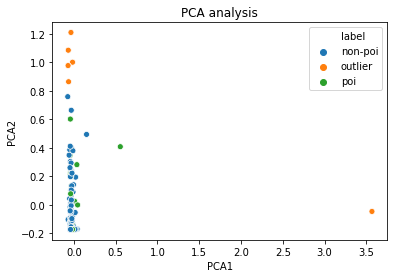

In [15]:
# Plot the 2 PCA components as scatter to visualize outliers
ax = sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='label')
ax.set_title('PCA analysis')
ax.figure.savefig('PCA_analysis_plot.png', dpi=300)

In [15]:
list_outliers_pca

Index(['BELDEN TIMOTHY N', 'KEAN STEVEN J', 'KITCHEN LOUISE',
       'LAVORATO JOHN J', 'SHAPIRO RICHARD S', 'TOTAL'],
      dtype='object')

In [16]:
df_enron.shape

(146, 20)

In [21]:
# Add PCA components to df_enron as new features
df_enron = pd.concat([df_enron, pca_df[['PCA1', 'PCA2']]], axis=1)

In [24]:
df_enron.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,PCA1,PCA2
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,0.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,...,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,0.0,0.021015,0.194580
BADUM JAMES P,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,257817.0,3486.0,...,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,-0.040584,-0.172437
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,0.0,0.0,-560222.0,-5104.0,5243487.0,56301.0,...,29.0,864523.0,0.0,False,0.0,465.0,1757552.0,0.0,-0.024012,-0.066678
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,...,0.0,2660303.0,0.0,False,1586055.0,0.0,3942714.0,0.0,0.040294,-0.169535
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,-82782.0,-201641.0,63014.0,129142.0,...,0.0,69.0,0.0,False,0.0,0.0,145796.0,0.0,-0.027090,-0.171985


In [36]:
# Remove outliers from the dataset
df_features_no_outliers = df_enron.drop(list_outliers_pca)
#X = (df_enron.drop('poi', axis=1))
X = scaler.fit_transform(df_features_no_outliers.drop('poi', axis=1))
y = df_features_no_outliers.poi

In [37]:
X.shape

(140, 21)

In [27]:
y.shape

(140,)

In [30]:
y.shape

(140,)

In [29]:
# Define relative importance for the features
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_enron.drop(
                                                           'poi', axis=1).columns)

[0.03975201 0.03903562 0.01478433 0.04803218 0.00830555 0.06219792
 0.00245497 0.07467218 0.06476825 0.06547343 0.04505162 0.16202998
 0.05431107 0.03969213 0.04128584 0.03607236 0.04804491 0.03949532
 0.00046285 0.07725386 0.03682363]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
# Convert results to Dataframe and sort it
df_features_importance = pd.DataFrame(feat_importances, columns=['values'])
df_features_importance = df_features_importance.sort_values(by='values')

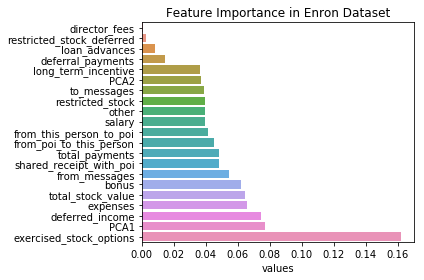

In [31]:
# Plot the feature importance as horizontal barplot
ax = sns.barplot(y=df_features_importance.index, x='values', data=df_features_importance,
           orient='h')
ax.set_title('Feature Importance in Enron Dataset')
plt.tight_layout()
ax.figure.savefig('feature_importance.png', dpi=300, orientation='landscape')

In [32]:
X.shape

(140, 21)

In [33]:
# Selecting the best features on our dataset
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#X = scaler.fit_transform(df_enron.drop('poi', axis=1))

selector_6 = SelectKBest(chi2, k=6)
selector_6.fit_transform(X, y)
best_6_feats = selector_6.get_support(indices=True)

selector_9 = SelectKBest(chi2, k=9)
selector_9.fit_transform(X, y)
best_9_feats = selector_9.get_support(indices=True)

selector_12 = SelectKBest(chi2, k=12)
selector_12.fit_transform(X, y)
best_12_feats = selector_12.get_support(indices=True)

selector_15 = SelectKBest(chi2, k=15)
selector_15.fit_transform(X, y)
best_15_feats = selector_15.get_support(indices=True)

In [34]:
best_15_feats

array([ 0,  1,  3,  4,  5,  8,  9, 10, 11, 13, 14, 15, 16, 18, 20])

In [35]:
# Print the list of 8, 10, 12 and 16 best features
selected_6_feats = list(df_enron.drop('poi', axis=1).columns[best_6_feats])
selected_9_feats = list(df_enron.drop('poi', axis=1).columns[best_9_feats])
selected_12_feats = list(df_enron.drop('poi', axis=1).columns[best_12_feats])
selected_15_feats = list(df_enron.drop('poi', axis=1).columns[best_15_feats])

print('Best 6 features: {}'.format(selected_6_feats))
print('\nBest 9 features: {}'.format(selected_9_feats))
print('\nBest 12 features: {}'.format(selected_12_feats))
print('\nBest 15 features: {}'.format(selected_15_feats))

Best 6 features: ['salary', 'loan_advances', 'bonus', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive']

Best 9 features: ['salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'shared_receipt_with_poi', 'PCA2']

Best 12 features: ['salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'PCA2']

Best 15 features: ['salary', 'to_messages', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'director_fees', 'PCA2']


In [71]:
# Test a simple model to see how many features should we use
len(selected_15_feats)

15

In [72]:
selected_15_feats

['salary',
 'to_messages',
 'total_payments',
 'loan_advances',
 'bonus',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'director_fees',
 'PCA2']

In [73]:
# Redefine X
X = scaler.fit_transform(df_features_no_outliers[selected_15_feats])
X.shape

(140, 15)

In [74]:
# Get ration of POI and non-POI
poi_class = df_features_no_outliers['poi'].value_counts()
print(poi_class / df_features_no_outliers.shape[0])

False    0.878571
True     0.121429
Name: poi, dtype: float64


In [75]:
# Set random seed to reproductibilty
np.random.seed(1234)

# Generate artificial samples with SMOTE to deal with class imbalance
from imblearn.over_sampling import SMOTE

# Define the resampling method
method = SMOTE(kind='regular', random_state=42)

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

# Use shuffle to mix generated synthetic samples
from sklearn.utils import shuffle
X_resampled,  y_resampled = shuffle(X_resampled,  y_resampled)

In [76]:
X_resampled.shape

(246, 15)

In [77]:
# Split your data X and y, into a training and a test set and fit the
# pipeline onto the training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,  y_resampled, test_size=0.3, random_state=0)

In [78]:
X_train.shape

(172, 15)

In [79]:
# Test the performance of a few classifiers with 6, 9, 12 and 15 best features
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
print(clf)
print('GaussianNB')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
print(clf)
print('RandomForestClassifier')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
print(clf)
print('LogisticRegression')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

GaussianNB(priors=None, var_smoothing=1e-09)
GaussianNB
0.7852941176470588
              precision    recall  f1-score   support

       False       0.48      0.79      0.60        34
        True       0.61      0.28      0.38        40

   micro avg       0.51      0.51      0.51        74
   macro avg       0.55      0.53      0.49        74
weighted avg       0.55      0.51      0.48        74

[[27  7]
 [29 11]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
RandomForestClassifier
0.9433823529411764
              precision    recall  f1-score   support

       False       0.89      0.91      0.90        34
        True  

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [86]:
# Plot the F1-score for different number of best features for RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
list_best_features = [selected_6_feats, selected_9_feats, selected_12_feats, selected_15_feats]
recall_score_list = []
precision_score_list = []
f1_score_list = []

for n_k_best_features in list_best_features:
    X = scaler.fit_transform(df_features_no_outliers[n_k_best_features])
    method = SMOTE(kind='regular', random_state=42)
    X_resampled, y_resampled = method.fit_sample(X, y)
    X_resampled,  y_resampled = shuffle(X_resampled,  y_resampled)
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled,  y_resampled, test_size=0.3, random_state=0)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    recall_score_list.append(recall_score(y_test, predicted))
    precision_score_list.append(precision_score(y_test, predicted))
    f1_score_list.append(f1_score(y_test, predicted))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [87]:
print(recall_score_list)
print(precision_score_list)
print(f1_score_list)

[0.9459459459459459, 0.9142857142857143, 0.9375, 0.9230769230769231]
[0.8536585365853658, 0.8205128205128205, 0.8108108108108109, 0.9]
[0.8974358974358975, 0.8648648648648648, 0.8695652173913043, 0.9113924050632911]


In [94]:
# Convert results into Dataframe
df_metrics_rf = pd.DataFrame({'recall':recall_score_list, 'precision':precision_score_list, 
                              'f1-score':f1_score_list}, index=[6,9,12,15])

In [97]:
# Inspect it
df_metrics_rf

,recall,precision,f1-score
6,0.945946,0.853659,0.897436
9,0.914286,0.820513,0.864865
12,0.937500,0.810811,0.869565
15,0.923077,0.900000,0.911392


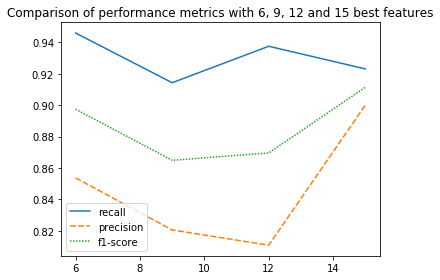

In [98]:
ax = sns.lineplot(data=df_metrics_rf)
ax.set_title('Comparison of performance metrics with 6, 9, 12 and 15 best features')
plt.tight_layout()
ax.figure.savefig('best_features_metrics.png', dpi=300, orientation='landscape')

In [80]:
# Set features to be used on analysis
features_list = ['poi'] + selected_15_feats
print(features_list)

['poi', 'salary', 'to_messages', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'director_fees', 'PCA2']


In [81]:
## Use GridSearchCV to optimize RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid 
param_grid = {
    'max_depth': [80, 90, 100, 110,150, 200],
    'max_features': [None, 'auto', 2, 3, 6, 9, 12],
    'min_samples_leaf': [2, 4, 6, 12],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'class_weight': ['balanced','balanced_subsample', {0:1, 1:6}, {0:1, 1:3}] 
}

In [83]:
X_train.shape

(172, 15)

In [84]:
# Define which model to use
model = RandomForestClassifier()
# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, 
param_grid = param_grid, cv = 5,
n_jobs = -1, scoring='f1', verbose=10)

grid_search_model.fit(X_train, y_train)
print(grid_search_model.best_params_)
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 9369 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 9506 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 9645 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 9925 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 10066 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 10209 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 10497 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 10642 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 10789 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 10936 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11085 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 11385 tasks      |

[Parallel(n_jobs=-1)]: Done 35097 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 35362 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 35629 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 35896 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 36165 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 36434 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 36705 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 36976 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 37249 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 37522 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 37797 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 38072 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 38349 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 38626 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 38905 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 39184 tasks 

{'class_weight': 'balanced_subsample', 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
0.9131541947664418


In [85]:
# Get performance metrics for the chosen model and parameters
#np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
"""clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)"""

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

print(clf)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
0.9595588235294118
              precision    recall  f1-score   support

       False       0.97      0.85      0.91        34
        True       0.89      0.97      0.93        40

   micro avg       0.92      0.92      0.92        74
   macro avg       0.93      0.91      0.92        74
weighted avg       0.92      0.92      0.92        74

[[29  5]
 [ 1 39]]


In [41]:
# Cross Validation of model using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
sss.get_n_splits(X_resampled, y_resampled)

recall_score_list = []
precision_score_list = []
f1_score_list = []

for train_index, test_index in sss.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    probs = clf.predict_proba(X_test)

    # Print the ROC curve, classification report and confusion matrix
    print(roc_auc_score(y_test, probs[:, 1]))
    print(classification_report(y_test, predicted))
    print(confusion_matrix(y_test, predicted))
    recall_score_list.append(recall_score(y_test, predicted))
    precision_score_list.append(precision_score(y_test, predicted))
    f1_score_list.append(f1_score(y_test, predicted))

print('Recall Score Mean: {}'.format(np.mean(recall_score_list)))
print('Precision Score Mean: {}'.format(np.mean(precision_score_list)))
print('F1 Score Mean: {}'.format(np.mean(f1_score_list)))

0.9919649379108839
              precision    recall  f1-score   support

       False       0.97      0.95      0.96        37
        True       0.95      0.97      0.96        37

   micro avg       0.96      0.96      0.96        74
   macro avg       0.96      0.96      0.96        74
weighted avg       0.96      0.96      0.96        74

[[35  2]
 [ 1 36]]
0.9722425127830534
              precision    recall  f1-score   support

       False       1.00      0.84      0.91        37
        True       0.86      1.00      0.92        37

   micro avg       0.92      0.92      0.92        74
   macro avg       0.93      0.92      0.92        74
weighted avg       0.93      0.92      0.92        74

[[31  6]
 [ 0 37]]
0.9693206720233748
              precision    recall  f1-score   support

       False       0.92      0.95      0.93        37
        True       0.94      0.92      0.93        37

   micro avg       0.93      0.93      0.93        74
   macro avg       0.93      0.93